In [38]:
import pandas as pd
import numpy as np
#import scipy

Read the data:

In [110]:
meter_list = pd.read_excel('gorilla_test_data.xlsx', sheet_name='meter_list')
forecast_table = pd.read_excel('gorilla_test_data.xlsx', sheet_name='forecast_table')
rate_table = pd.read_excel('gorilla_test_data.xlsx', sheet_name='rate_table')

**TASK 1)**
The first task consists of calculating the total forecast and cost over the specified period. We will split this task in the following subtasks:
1) Determining the date ranges for which different rates (p/kWh) apply.
2) Grouping the dates in forecast_table by date range and summing the forecasts per date range.
3) Calculating the cost per date range.
4) Summing the all costs and forecasts per meter and generate the requested table.

1) We will thus commence with the first subtask, determining the date ranges.

In [311]:
date_range = rate_table["date"].drop_duplicates()
date_range = pd.DatetimeIndex(date_range)

2) Grouping the dates in forecast_table by date range and summing the forecasts per date range. The result is a table which lists the forecasted consumption for each period in the date range.

In [315]:
fc_table = forecast_table
fc_table.index = fc_table["date"]
fc_table["period"] = date_range[date_range.searchsorted(fc_table.index,side='right')-1]
fc_table = fc_table.groupby(['meter_id','period']).agg(kwh = ("kwh","sum")).reset_index()
fc_table = fc_table.rename(columns={"period":"date"})
fc_table.head(10)

,meter_id,date,kwh
0,14676236,2020-04-01,1769.354787
1,14676236,2020-10-01,8565.582872
2,14676236,2021-04-01,4717.664057
3,14676236,2021-10-01,8512.419037
4,14676236,2022-04-01,5375.856768
5,14676236,2022-10-01,37.122479
6,34509937,2020-04-01,8217.361143
7,34509937,2020-10-01,24558.935299
8,34509937,2021-04-01,9900.663301
9,34509937,2021-10-01,22644.929722


3) Calculate the cost per datarange. To do this we need to select the range aq_kwh falls into. We first merge the rates_table with the meter list on exit_zone resulting in the rates-id (rt_id) table. To be able to compare the aq_kwh values with the interval boundaries we first replace the NaN values with infinity. After selecting the adequate rows, rt_id is merged with fc_table on meter_id and date resulting in rt_id_fc. We can now easily calculate the cost of the forecast per date range.

In [316]:
# crop rates table
rt = rate_table.loc[rate_table['exit_zone'].isin(meter_list['exit_zone'])]
rt_id = pd.merge(rt,meter_list,on='exit_zone')
rt_id=rt_id.replace(np.nan,np.inf)

rt_id=rt_id.loc[(rt_id["aq_kwh"]>=rt_id["aq_min_kwh"]) & (rt_id["aq_kwh"]<rt_id["aq_max_kwh"])]
rt_id = rt_id.loc[rt_id["date"].isin(fc_table["date"])]

rt_id_fc = pd.merge(rt_id,fc_table, on=["meter_id","date"])

rt_id_fc["price_fc"] = round(rt_id_fc["rate_p_per_kwh"]*rt_id_fc["kwh"]/100.,2)

rt_id_fc.head(10)


,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh,meter_id,aq_kwh,kwh,price_fc
0,2020-04-01,EA1,0,73200.0,0.2652,14676236,28978,1769.354787,4.69
1,2020-10-01,EA1,0,73200.0,0.2970,14676236,28978,8565.582872,25.44
2,2021-04-01,EA1,0,73200.0,0.3327,14676236,28978,4717.664057,15.70
3,2021-10-01,EA1,0,73200.0,0.3726,14676236,28978,8512.419037,31.72
4,2022-04-01,EA1,0,73200.0,0.4173,14676236,28978,5375.856768,22.43
5,2022-10-01,EA1,0,73200.0,0.4674,14676236,28978,37.122479,0.17
6,2020-04-01,NT1,73200,732000.0,0.2181,50264822,265667,31661.043470,69.05
7,2020-10-01,NT1,73200,732000.0,0.2443,50264822,265667,86324.519069,210.89
8,2021-04-01,NT1,73200,732000.0,0.2736,50264822,265667,39885.529667,109.13
9,2021-10-01,NT1,73200,732000.0,0.3064,50264822,265667,75861.535236,232.44


4) We can now easily calculate the total forecast and cost (in pounds)

In [79]:
rt_id_fc=rt_id_fc.groupby("meter_id").agg({"kwh":"sum","price_fc":"sum"}).reset_index()
rt_id_fc=rt_id_fc.rename(columns={"meter_id": "Meter ID", "kwh": "Total Estimated Consumption (kWh)", "price_fc":"Total Cost ("u"\u00A3"")"})

rt_id_fc

,Meter ID,Total Estimated Consumption (kWh),Total Cost (£)
0,14676236,28978.0,100.15
1,34509937,78324.0,275.49
2,50264822,265667.0,731.24
3,88357331,484399.0,1433.15


The function transportation_cost(meter_list, forecast_table, rate_table) combines all above mentioned steps.

In [322]:
# Function:     Transportation_cost
# Function calculates the transportation cost as specified in "Gorilla Data Engineer Assessment.pdf"
# INPUTS:               All inputs and outputs are dataframes defined in "gorilla_test_data.xlsx" or "Gorilla Data Engineer Assessment.pdf"
# forecast_table
# rate_table
# OUTPUT:
# transp_cost:          Transport cost

def transportation_cost(meter_list,forecast_table,rate_table):

    # Determine the date ranges for which a different pricing rate is used
    date_range = rate_table["date"].drop_duplicates()
    date_range = pd.DatetimeIndex(date_range)

    # Determine the date range each forecast in forecast table belongs to.
    forecast_table.index = forecast_table["date"]
    forecast_table["period"] = date_range[date_range.searchsorted(forecast_table.index,side='right')-1]
    forecast_table = forecast_table.groupby(['meter_id','period']).agg(kwh = ("kwh","sum")).reset_index()
    forecast_table = forecast_table.rename(columns={"period":"date"})

    # drop the unused exit zones in rate_table
    rate_id_table = rate_table.loc[rate_table['exit_zone'].isin(meter_list['exit_zone'])]
   
    # merge meter_list and rate_table on exit zone.
    rate_id_table = pd.merge(rate_id_table,meter_list,on='exit_zone')
   
    # replace nan values by np.inf such that boolean questions can be asked
    rate_id_table = rate_id_table.replace(np.nan,np.inf)
    
    # select the rates that apply according to aq_kwh
    rate_id_table = rate_id_table.loc[(rate_id_table["aq_kwh"]>=rate_id_table["aq_min_kwh"]) & (rate_id_table["aq_kwh"]<rate_id_table["aq_max_kwh"])]

    # select date ranges for which we want toi calculate the price
    rate_id_table = rate_id_table.loc[rate_id_table["date"].isin(forecast_table["date"])]

    # merge the rate_table with the forecast table on date and meter id
    transp_cost = pd.merge(rate_id_table,forecast_table, on=["meter_id","date"])
    # determine the price for each rate period as specified in the original rate table.
    transp_cost["price_fc"] = round(transp_cost["rate_p_per_kwh"]*transp_cost["kwh"]/100.,2)

    # For each meter ID calculate the total forecast and cost and store these values in the requested table
    transp_cost=transp_cost.groupby("meter_id").agg({"kwh":"sum","price_fc":"sum"}).reset_index()
    transp_cost=transp_cost.rename(columns={"meter_id": "Meter ID", "kwh": "Total Estimated Consumption (kWh)", "price_fc":"Total Cost ("u"\u00A3"")"})
    transp_cost["Total Estimated Consumption (kWh)"] = transp_cost["Total Estimated Consumption (kWh)"].apply('{0:.2f}'.format)

    return transp_cost


result = transportation_cost(meter_list,forecast_table,rate_table)
result


,Meter ID,Total Estimated Consumption (kWh),Total Cost (£)
0,14676236,28978.00,100.15
1,34509937,78324.00,275.49
2,50264822,265667.00,731.24
3,88357331,484399.00,1433.15


**TASK 2)**
Write a function that generates a list of random meters of any size. Examples of valid
exit zones can be found in the rate table. You may randomly generate the annual
quantity. 

In [318]:
import random

In [212]:
# Function: generate_meter_list
# The function generates a new meter list (see gorilla_test_data.xlsx sheet meter_list)
# with specified size, random exit zones and annual quantities.
# Input:
# size:                 int, the amount of meters that wil be considered
# OPTIONAL exit_zones:  array containing the possible exit zones
# OUTPUT:
# meter_list:           dataframe, meter list as defined in gorilla_test_data.xlsx sheet meter_list,
#                       with specified size
def generate_meter_list(size,exit_zones=rate_table["exit_zone"].unique()):
    meter_id = random.sample(range(10000000,100000000),size) #numpy.random.choice was too slow
    ex_z = np.random.choice(exit_zones,size)
    aq_kwh = np.random.randint(1000000,size=size)
    meter_list = pd.DataFrame({'meter_id':meter_id,'aq_kwh':aq_kwh,'exit_zone':ex_z})

    return meter_list



**TASK 3)** Write a function that generates mock consumption data given a list of meters and a
start date and duration (number of days in the forecast). The data may be completely
random and it doesn't have to match with the meters' annual quantities either.

In [257]:
# Tmin 1/04/2020  0:00:00
# Tmax 1/10/2024  0:00:00

from datetime import timedelta


# Function:     generate_consumption_data
# The function generates a new forecast table (see gorilla_test_data.xlsx sheet forecast_table)
# INPUTS:
# meter_id_column:      dataframe column containing the meter ID's
# start_date:           Timestamp of the first day that is considered
# duration:             int representing the number of days after start date that will be forecasted
# Output:
# forecast table:       dataframe, forecast table as defined in gorilla_test_data.xlsx sheet forecast_table.
def generate_consumption_data(meter_id_column, start_date, duration):
    end_date = start_date + timedelta(days = duration)
    date_range = pd.date_range(start_date,end_date)

    dates = np.tile(date_range,len(meter_id_column))
    
    meter_id = np.repeat(list(meter_id_column),duration+1)

    kwh = np.random.uniform(0.,1000.,len(meter_id))
    forecast_table = pd.DataFrame({'meter_id':meter_id,'date':dates,'kwh':kwh})

    return forecast_table

ml = generate_meter_list(1)
timetime = pd.Timestamp(year = 2020, month=4, day = 1, hour=0)

fc = generate_consumption_data(ml["meter_id"],timetime,1644)
fc


,meter_id,date,kwh
0,52508024,2020-04-01,766.552854
1,52508024,2020-04-02,76.926872
2,52508024,2020-04-03,708.956487
3,52508024,2020-04-04,813.937824
4,52508024,2020-04-05,643.831994
...,...,...,...
1640,52508024,2024-09-27,225.374727
1641,52508024,2024-09-28,104.674494
1642,52508024,2024-09-29,84.281371
1643,52508024,2024-09-30,324.307600


**TASK 4)** 

1) Write a function that takes as an input a meter list and a consumption forecast table
and that calculates the transportation cost table (i.e., best take your logic from task 1
and wrap it in a function). See function transportation_cost(meter_list, forecast_table, rate_table) above.

2) Benchmark this function using meter lists of different sizes
and consumption forecasts for periods of different lengths. How does the function scale
for larger sets of data?


**BENCHMARK:** To benchmark the performance of the function "transportation cost", we will assess its timings for varying amounts of meters and varying durations.
The amount of meters we will test for are: 1, 5, 10, 50, 100, 500 , 1000, 5000, 10000. The durations we will test for are (with start date 2020-04-01, the first date available in the rate table): 1, 10,100, 1000, 1644.
Each combination of meter amount and duration will be tested 150 times, the first 50 iterations will be dropped to account for burn in. Benchmarking takes approximately 6 minutes to complete.

In [310]:
import time

start_date = pd.Timestamp(year = 2020, month=4, day = 1, hour=0)
duration = np.array([1,10,100,1000,1644])

meter_batch = np.array([1,5,10,50,100,500,1000,5000,10000])

burn_in = 50
tests = 100

mean_timings = np.zeros((len(duration),len(meter_batch)))

for days in range(len(duration)):
    for batch in range(len(meter_batch)):

        np.random.seed(0)
        ml = generate_meter_list(size=meter_batch[batch])
        ft = generate_consumption_data(ml["meter_id"],start_date=start_date,duration=int(duration[days]))

        timing = 0
        for i in range(burn_in):
            cost = transportation_cost(ml,ft,rate_table)
        
        for i in range(tests):
            start = time.time()
            cost = transportation_cost(ml,ft,rate_table)
            end = time.time()
            timing+=(end-start)

        mean_timings[days,batch] = timing/float(tests)
            

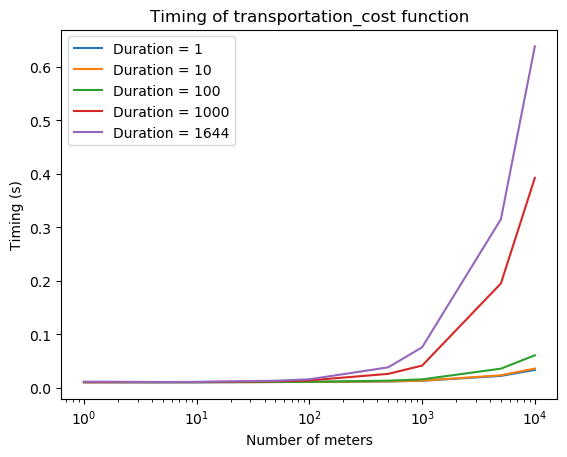

In [308]:
import matplotlib.pyplot as plt
fig = plt.figure
plt.semilogx(meter_batch,mean_timings[0,:], label="Duration = 1")
plt.semilogx(meter_batch,mean_timings[1,:], label="Duration = 10")
plt.semilogx(meter_batch,mean_timings[2,:], label="Duration = 100")
plt.semilogx(meter_batch,mean_timings[3,:], label="Duration = 1000")
plt.semilogx(meter_batch,mean_timings[4,:], label="Duration = 1644")
plt.xlabel("Number of meters")
plt.ylabel("Timing (s)")
plt.legend(loc="upper left")
plt.title('Timing of transportation_cost function')
plt.show()

The figure above shows the mean timings of the transportation_cost function. We observe that as the number of meters increases an exponential increase in timings can be observed for all durations. We can conclude that the function does not scale well for large datasets, especially for cases where long term forecasts need to be calculated. (The figure is included in the git repository as Timings.PNG)

**TASK 5)** What are your observations after benchmarking? Are there any steps in the cost
calculation that can be improved? How would you go about improving the performance
of this calculation?

Observations: see text beneath plot.

Improvements to the function transportation_cost: 
1) A lot of computational overhead is generated by storing all intermediate dataframes in different variables. E.g. when rate_id_table and rate_forecast are merged, the result is sored in a new dataframe transp_cost. The dataframes rate_id_table and rate_foracast will still be in memory. This becomes an issue when boths dataframes are large, due to a high amount of meters and a high duration. The creation of a third large dataframe will cause, when considering the memory hierarchy of a computer and the cache-pyramid, the other large dataframes to be written to lower levels of the memory hierarchy. This writing will take up precious cpu-time.
2) The creation of new dataframes, addition of new columns, etc creates overhead.